In [1]:
import sys
print(f"Current Python executable: {sys.executable}")

%pip install -U pip setuptools wheel
%pip install geopandas

import sys
import pandas as pd
import numpy as np
import geopandas as gpd  
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Verify geopandas is installed correctly
print(f"Python executable: {sys.executable}")
print(f"GeoPandas version: {gpd.__version__}")

DATA = Path("../sf-rent-trends/data")  
FILES = {
    "zori": DATA/"zori_zip_sf.csv",
    "sf_zip_geo": DATA/"sf_zip_codes.geojson",
    "muni": DATA/"muni_stops.csv",
    "sfpd": DATA/"sfpd_incidents.csv",
    "airbnb": DATA/"airbnb_sf_listings.csv",
    "acs_income": DATA/"acs_income_s1901.csv"
}
for k, p in FILES.items():
    assert p.exists(), f"Missing file: {p}"

Current Python executable: /opt/conda/envs/anaconda-panel-2023.05-py310/bin/python
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Python executable: /opt/conda/envs/anaconda-panel-2023.05-py310/bin/python
GeoPandas version: 1.1.1


In [4]:
meta_cols = [
    "RegionID", "SizeRank", "RegionName", "RegionType",
    "City", "State", "StateName", "Metro", "CountyName"
]


zori_ca = zori[zori["State"].eq("CA")].copy()


cols_as_dt = pd.to_datetime(pd.Index(zori_ca.columns), errors="coerce")
date_cols = list(pd.Index(zori_ca.columns)[cols_as_dt.notna()])

date_cols = [c for c in date_cols if c not in meta_cols]

zori_long = zori_ca.melt(
    id_vars=[c for c in meta_cols if c in zori_ca.columns],
    value_vars=date_cols,
    var_name="date",
    value_name="zori"
)

zori_long["date"] = pd.to_datetime(zori_long["date"], errors="coerce")
zori_long = zori_long.dropna(subset=["date"])

zori_long.rename(columns={"RegionName": "ZIP"}, inplace=True)
zori_long["ZIP"] = zori_long["ZIP"].astype(str).str.zfill(5)




/tmp/ipykernel_1743/223196143.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cols_as_dt = pd.to_datetime(pd.Index(zori_ca.columns), errors="coerce")


In [5]:
sf_zip = gpd.read_file(FILES["sf_zip_geo"]).to_crs(4326)
sf_zip["ZIP"] = sf_zip["zip_code"].astype(str).str.zfill(5)  # column name may be 'zip_code' or similar
sf_zip_list = set(sf_zip["ZIP"])


In [6]:
zori_sf = zori_long[zori_long["ZIP"].isin(sf_zip_list)].copy()
latest_date = zori_sf["date"].max()
zori_latest = zori_sf.loc[zori_sf["date"].eq(latest_date), ["ZIP","zori"]].reset_index(drop=True)


In [8]:
def load_muni_points(path):
    try:
        gdf = gpd.read_file(path)
        if "geometry" in gdf and not gdf.geometry.is_empty.all():
            return gdf.to_crs(4326)[["geometry"]].copy()
    except Exception:
        pass  

    df = pd.read_csv(path)

    norm = {c.lower().strip(): c for c in df.columns}

    lon_candidates = [
        "longitude", "long", "lon", "stop_lon", "x", "xcoord", "x_coord", "xcoordinate", "x_coordinate"
    ]
    lat_candidates = [
        "latitude", "lat", "stop_lat", "y", "ycoord", "y_coord", "ycoordinate", "y_coordinate"
    ]

    def find_col(candidates):
        for lc, orig in norm.items():
            if lc in candidates:
                return orig
        for lc, orig in norm.items():
            if any(c in lc for c in candidates):
                return orig
        return None

    lon_col = find_col(lon_candidates)
    lat_col = find_col(lat_candidates)

    if lon_col is None or lat_col is None:
        raise KeyError(
            f"Could not find longitude/latitude columns in {path}. "
            f"Found columns: {list(df.columns)}"
        )

    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
    df = df.dropna(subset=[lon_col, lat_col]).copy()

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs=4326
    )
    return gdf[["geometry"]].copy()

# ---- Use the loader, then join to ZIPs ----
muni_g = load_muni_points(FILES["muni"])          # geometry (EPSG:4326)
muni_zip = gpd.sjoin(muni_g, sf_zip[["ZIP","geometry"]], how="inner", predicate="within")
stops_per_zip = muni_zip.groupby("ZIP").size().rename("muni_stops").reset_index()



In [11]:
import csv

def load_sfpd_points(path, start=None, end=None, sf_zip_gdf=None):
    """
    Robustly load SFPD incidents from CSV/Geo file and return a GeoDataFrame in EPSG:4326,
    optionally date-filtered and (if sf_zip_gdf is provided) spatially joined to ZIPs.
    """
    try:
        gdf = gpd.read_file(path).to_crs(4326)
        date_col = next((c for c in gdf.columns if "date" in c.lower()), None)
        if date_col is not None:
            gdf[date_col] = pd.to_datetime(gdf[date_col], errors="coerce")
        if start is not None and end is not None and date_col is not None:
            gdf = gdf[(gdf[date_col] >= start) & (gdf[date_col] <= end)]
        if sf_zip_gdf is not None:
            gdf = gpd.sjoin(gdf, sf_zip_gdf[["ZIP","geometry"]], how="inner", predicate="within")
        return gdf, date_col
    except Exception:
        pass 
    try:
        df = pd.read_csv(path, parse_dates=["Incident Datetime"], low_memory=False)
        date_col = "Incident Datetime"
    except Exception:
        df = pd.read_csv(
            path,
            engine="python",
            sep=",",
            quotechar='"',
            doublequote=True,
            escapechar="\\",
            on_bad_lines="skip",  
            dtype=str
        )
        date_candidates = ["Incident Datetime", "Incident Date", "Report Datetime", "Date", "Occurrence Date"]
        date_col = next((c for c in date_candidates if c in df.columns), None)
        if date_col is None:
            date_col = next((c for c in df.columns if "date" in c.lower()), None)
        if date_col is not None:
            df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    def find_col(cols, candidates):
        cols_l = {c.lower(): c for c in cols}
        for cand in candidates:
            if cand in cols_l:
                return cols_l[cand]
        for lc, orig in cols_l.items():
            if any(c in lc for c in candidates):
                return orig
        return None

    lon_col = find_col(
        df.columns,
        ["longitude", "lon", "long", "x", "xcoord", "x_coord", "stop_lon"]
    )
    lat_col = find_col(
        df.columns,
        ["latitude", "lat", "y", "ycoord", "y_coord", "stop_lat"]
    )

    if lon_col is None or lat_col is None:
        raise KeyError(
            f"Could not find longitude/latitude columns in SFPD file. Columns: {list(df.columns)}"
        )

    # Coerce to numeric and drop bad rows
    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")
    df[lat_col]  = pd.to_numeric(df[lat_col], errors="coerce")
    df = df.dropna(subset=[lon_col, lat_col]).copy()

    # Date filter if we have a date column
    if date_col is not None and start is not None and end is not None:
        df = df[(df[date_col] >= start) & (df[date_col] <= end)]

    # Build GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs=4326
    )

    # Spatial join to ZIPs if provided
    if sf_zip_gdf is not None:
        gdf = gpd.sjoin(gdf, sf_zip_gdf[["ZIP","geometry"]], how="inner", predicate="within")

    return gdf, date_col


In [12]:
# Align to rent window (last 12 months)
end = latest_date
start = (latest_date - pd.offsets.DateOffset(years=1)) + pd.offsets.Day(1)

sfpd_gdf, sfpd_date_col = load_sfpd_points(
    FILES["sfpd"],
    start=start, end=end,
    sf_zip_gdf=sf_zip  # to attach ZIPs immediately
)

incidents_per_zip = sfpd_gdf.groupby("ZIP").size().rename("incidents_12m").reset_index()


In [13]:
ab = pd.read_csv(FILES["airbnb"])
ab = ab.dropna(subset=["latitude","longitude"])
ab_g = gpd.GeoDataFrame(ab, geometry=gpd.points_from_xy(ab["longitude"], ab["latitude"]), crs=4326)
ab_zip = gpd.sjoin(ab_g, sf_zip[["ZIP","geometry"]], how="inner", predicate="within")
listings_per_zip = ab_zip.groupby("ZIP").size().rename("airbnb_listings").reset_index()

# area in km^2
sf_zip_m = sf_zip.to_crs(3857)  # meters
area_km2 = sf_zip_m.assign(km2 = sf_zip_m.area/1e6)[["ZIP","km2"]]
tourism_zip = listings_per_zip.merge(area_km2, on="ZIP", how="left")
tourism_zip["airbnb_density"] = tourism_zip["airbnb_listings"] / tourism_zip["km2"]
tourism_zip = tourism_zip[["ZIP","airbnb_density"]]


In [18]:
import os, requests, pandas as pd

def get_acs_income_zip(sf_zips, year=2023, api_key=None, verbose=False):
    """
    Fetch median household income by ZCTA (ZIP) for given list of zips.
    Tries ACS 5-year SUBJECT S1901 (Median Household Income) first,
    then falls back to ACS 5-year DETAILED B19013_001E if needed.

    Returns: DataFrame with columns ['ZIP', 'median_income'].
    """
    # Endpoints to try in order: (dataset_path, var_name, nice_label)
    attempts = [
        (f"https://api.census.gov/data/{year}/acs/acs5/subject",  "S1901_C01_012E", "S1901 subject (5yr)"),
        (f"https://api.census.gov/data/{year}/acs/acs5",          "B19013_001E",    "B19013 detailed (5yr)"),
    ]

    def call_endpoint(base_url, var, zips_chunk):
        params = {
            "get": f"NAME,{var}",
            "for": f"zip code tabulation area:{','.join(zips_chunk)}",
        }
        if api_key:
            params["key"] = api_key
        r = requests.get(base_url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        cols, vals = data[0], data[1:]
        df = pd.DataFrame(vals, columns=cols)
        df = df.rename(columns={
            "zip code tabulation area": "ZIP",
            var: "median_income"
        })[["ZIP", "median_income"]]
        df["ZIP"] = df["ZIP"].astype(str).str.zfill(5)
        df["median_income"] = pd.to_numeric(df["median_income"], errors="coerce")
        return df

    # chunk zips (Census API allows up to ~50 per call)
    chunks = [sf_zips[i:i+50] for i in range(0, len(sf_zips), 50)]
    frames = []

    for base_url, var, label in attempts:
        frames = []
        try:
            for chunk in chunks:
                frames.append(call_endpoint(base_url, var, chunk))
            out = pd.concat(frames, ignore_index=True)
            if verbose:
                print(f"Fetched {len(out)} rows via {label}")
            return out  # success
        except requests.HTTPError as e:
            if verbose:
                print(f"{label} failed: {e}\nTrying next endpoint...")
            continue

    raise RuntimeError(
        "All ACS attempts failed. Try a different year (e.g., 2022), "
        "or verify your ZIP list and network."
    )

# Usage (replace your previous call):
# sf_zips should be your list of SF ZIPs (strings) from the ZIP polygons set
# API key optional for small calls; set env var CENSUS_API_KEY to use one.
API_KEY = os.environ.get("CENSUS_API_KEY", None)
income_zip = get_acs_income_zip(sorted(list(sf_zip_list)), year=2023, api_key=API_KEY, verbose=True)



Fetched 27 rows via S1901 subject (5yr)


In [19]:
df = (zori_latest
      .merge(stops_per_zip, on="ZIP", how="left")
      .merge(incidents_per_zip, on="ZIP", how="left")
      .merge(tourism_zip, on="ZIP", how="left")
      .merge(income_zip, on="ZIP", how="left"))

# fill/clean
for c in ["muni_stops","incidents_12m","airbnb_density"]:
    df[c] = df[c].fillna(0)
df = df.dropna(subset=["median_income"]).copy()


In [20]:
df = (zori_latest
      .merge(stops_per_zip, on="ZIP", how="left")
      .merge(incidents_per_zip, on="ZIP", how="left")
      .merge(tourism_zip, on="ZIP", how="left")
      .merge(income_zip, on="ZIP", how="left"))

# fill harmless zeros for counts; income can be missing if ZCTA mismatch—drop or impute
for c in ["muni_stops","incidents_12m","airbnb_density"]:
    df[c] = df[c].fillna(0)
df = df.dropna(subset=["median_income"]).copy()

# optional transforms
df["log_rent"] = np.log(df["zori"])
df["log_income"] = np.log(df["median_income"].clip(lower=1))
df["incidents_per_stop"] = df["incidents_12m"] / df["muni_stops"].replace(0, np.nan)


<Figure size 640x480 with 0 Axes>

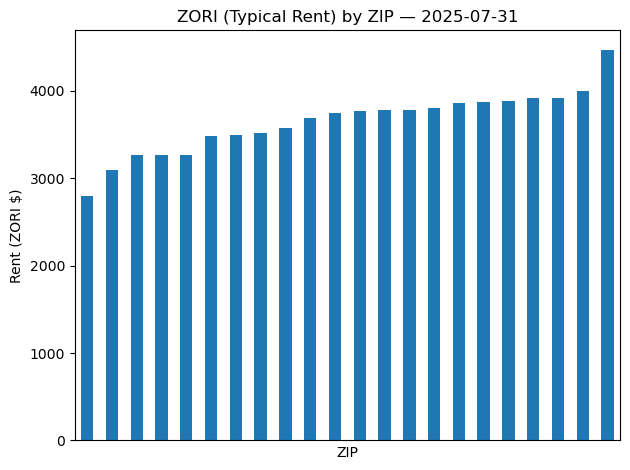

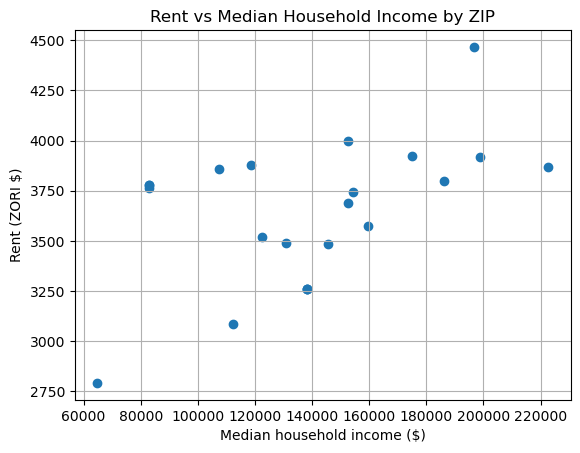

In [21]:
plt.figure()
df.sort_values("zori").plot(x="ZIP", y="zori", kind="bar", legend=False)
plt.title(f"ZORI (Typical Rent) by ZIP — {latest_date.date()}")
plt.xlabel("ZIP")
plt.ylabel("Rent (ZORI $)")
plt.xticks([], [])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.scatter(df["median_income"], df["zori"])
ax.set_title("Rent vs Median Household Income by ZIP")
ax.set_xlabel("Median household income ($)")
ax.set_ylabel("Rent (ZORI $)")
plt.grid(True); plt.show()


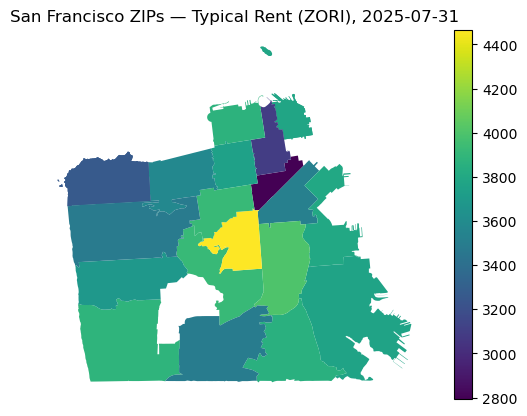

In [22]:
gdf = sf_zip.merge(df, on="ZIP", how="left")
ax = gdf.plot(column="zori", legend=True)
plt.title(f"San Francisco ZIPs — Typical Rent (ZORI), {latest_date.date()}")
plt.axis('off'); plt.show()


In [23]:
df["stops_100"] = df["muni_stops"] / 100.0
df["incidents_k"] = df["incidents_12m"] / 1000.0

model = smf.ols("log_rent ~ log_income + stops_100 + incidents_k + airbnb_density", data=df).fit(cov_type="HC3")
print(model.summary())

# Quick interpretation cell (plain language)
coef = model.params.round(3)
print(
    f"A 10% higher median income is associated with ~{(coef['log_income']*0.10):.3f} change in log rent, "
    "holding other factors fixed (robust SEs)."
)


                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                    0.9753
Date:                Wed, 03 Sep 2025   Prob (F-statistic):              0.447
Time:                        06:17:13   Log-Likelihood:                 25.239
No. Observations:                  22   AIC:                            -40.48
Df Residuals:                      17   BIC:                            -35.02
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.6066      1.136      5.